# Dataset Define

In [1]:
import torch

class Dataset():
    def __init__(self, target = "FP", seed = 42, batch_size = 128, root = "/SSD2/bgkang/Chemomile/data/"):
        import pandas as pd

        self.batch_size = batch_size
        self.df = pd.read_csv(f'{root}/TOXICITY/{target}.csv', index_col = 0)
        self.mean = self.df['Value'].mean()
        self.std = self.df['Value'].std()

        self._buildDataset()
        self._buildLoader(seed = seed)

        return

    def _buildDataset(self):
        from torch_geometric.utils.smiles import from_smiles
        self.total_set = []
        for idx, item in self.df.iterrows():
            data = from_smiles(item['SMILES'])
            data.x = data.x.to(torch.float)
            data.edge_attr = data.edge_attr.to(torch.float)
            data.y = float((item['Value'] - self.mean) / self.std)
            self.total_set.append(data)

        return

    def _buildLoader(self, seed):
        import random
        from torch_geometric.loader import DataLoader
        
        random.seed(seed)

        random.shuffle(self.total_set)

        training_set = [data for data in self.total_set[:int(0.8 * len(self.total_set))]]
        validation_set = [data for data in self.total_set[int(0.8 * len(self.total_set)):int(0.9 * len(self.total_set))]]
        test_set = [data for data in self.total_set[int(0.9 * len(self.total_set)):]]

        self.training_loader = DataLoader(training_set, batch_size = self.batch_size)
        self.validation_loader = DataLoader(validation_set, batch_size = self.batch_size)
        self.test_loader = DataLoader(test_set, batch_size = self.batch_size)

        return

In [2]:
dataset = Dataset(target = "mouse_intraperitoneal_LD50", batch_size = 512)

# Model Define

In [3]:
parameters = dict(
    hidden_size = 256,
    dropout = 0.200,
    num_layers = 4,
    num_timesteps = 4,
    lr_init = 0.01,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 200

In [4]:
class Featurizer(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.bn = torch.nn.BatchNorm1d(output_size)
        self.act = torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        x = self.act(x)

        return x

atomFeature = Featurizer(9, parameters['hidden_size']).to(device)
edgeFeature = Featurizer(3, parameters['hidden_size']).to(device)

In [5]:
from torch_geometric.nn.models import AttentiveFP
from copy import deepcopy

model = AttentiveFP(
    in_channels = parameters['hidden_size'],
    hidden_channels = parameters['hidden_size'],
    out_channels = 1,
    edge_dim = parameters['hidden_size'],
    num_layers = parameters['num_layers'],
    num_timesteps = parameters['num_timesteps'],
    dropout = parameters['dropout'],
).to(device)

best_model = deepcopy(model)

In [6]:
optim = torch.optim.Adam(model.parameters(),
                         lr = parameters['lr_init'])
loss = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

history = {
    'training_loss' : [],
    'validation_loss' : [],
}

In [7]:
minValLoss = 10E12
for epoch in range(EPOCHS):
    training_loss = 0.0; validation_loss = 0.0
    
    # Training
    model.train()

    for data in dataset.training_loader:
        data = data.to(device)
        out = model(x = atomFeature(data.x),
                    edge_index = data.edge_index,
                    edge_attr = edgeFeature(data.edge_attr),
                    batch = data.batch)
        loss_obj = loss(out.flatten(), data.y)
        training_loss += loss_obj.mean().item()

        optim.zero_grad()
        loss_obj.backward()
        optim.step()

    training_loss /= len(dataset.training_loader)
    history['training_loss'].append(training_loss)
    
    # Validation
    model.eval()
    
    for data in dataset.validation_loader:
        data = data.to(device)
        out = model(x = atomFeature(data.x),
                    edge_index = data.edge_index,
                    edge_attr = edgeFeature(data.edge_attr),
                    batch = data.batch)
        loss_obj = loss(out.flatten(), data.y)
        validation_loss += loss_obj.mean().item()

    validation_loss /= len(dataset.validation_loader)
    history['validation_loss'].append(validation_loss)

    scheduler.step(validation_loss)

    if (validation_loss < minValLoss):
        minValLoss = validation_loss
        best_model = deepcopy(model)

    print("EPOCH: %04d\tTrn. Loss: %10.06f\tVal. Loss: %10.06f\tLR: %10.6f" % (epoch, training_loss, validation_loss, scheduler.get_last_lr()[0]))

EPOCH: 0000	Trn. Loss:  10.269493	Val. Loss:   0.931289	LR:   0.010000
EPOCH: 0001	Trn. Loss:   0.873925	Val. Loss:   0.915451	LR:   0.010000
EPOCH: 0002	Trn. Loss:   0.845401	Val. Loss:   0.856091	LR:   0.010000
EPOCH: 0003	Trn. Loss:   0.810968	Val. Loss:   0.815494	LR:   0.010000
EPOCH: 0004	Trn. Loss:   0.801085	Val. Loss:   0.812800	LR:   0.010000
EPOCH: 0005	Trn. Loss:   0.781860	Val. Loss:   0.803633	LR:   0.010000
EPOCH: 0006	Trn. Loss:   0.773778	Val. Loss:   0.809371	LR:   0.010000
EPOCH: 0007	Trn. Loss:   0.763939	Val. Loss:   0.776899	LR:   0.010000
EPOCH: 0008	Trn. Loss:   0.743507	Val. Loss:   0.749780	LR:   0.010000
EPOCH: 0009	Trn. Loss:   0.735523	Val. Loss:   0.744743	LR:   0.010000
EPOCH: 0010	Trn. Loss:   0.729738	Val. Loss:   0.748202	LR:   0.010000
EPOCH: 0011	Trn. Loss:   0.739210	Val. Loss:   0.741783	LR:   0.010000
EPOCH: 0012	Trn. Loss:   0.748848	Val. Loss:   0.762119	LR:   0.010000
EPOCH: 0013	Trn. Loss:   0.735911	Val. Loss:   0.779511	LR:   0.010000
EPOCH:

# Loss Curve

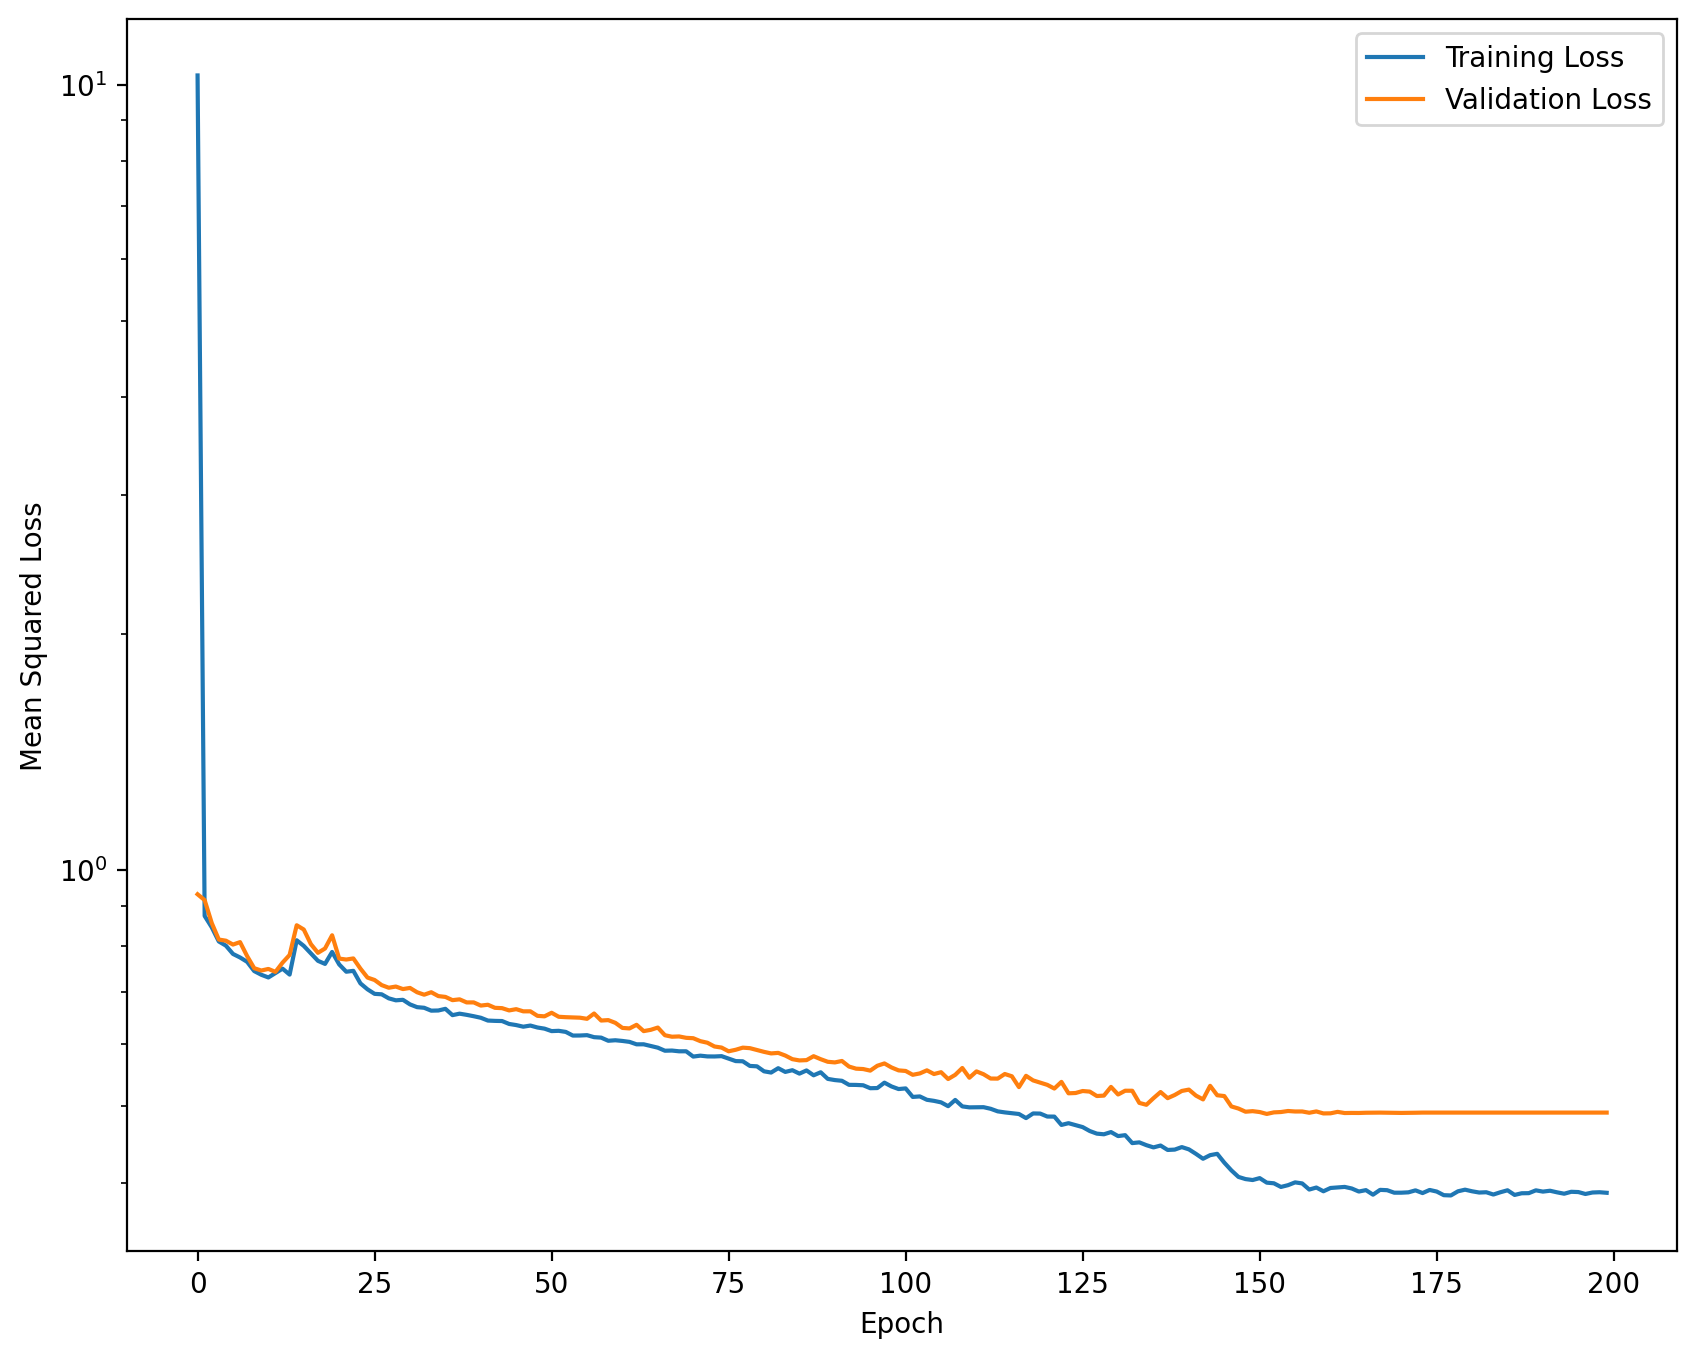

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,8), dpi = 200)
ax = plt.gca()

ax.plot(range(EPOCHS), history['training_loss'], label = 'Training Loss')
ax.plot(range(EPOCHS), history['validation_loss'], label = 'Validation Loss')

ax.set_yscale('log')
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Squared Loss")
ax.legend()

plt.show()

# Parity Plot

In [9]:
import numpy as np

true = []; pred = []
for data in dataset.test_loader:
    data = data.to(device)
    out = best_model(x = atomFeature(data.x),
                edge_index = data.edge_index,
                edge_attr = edgeFeature(data.edge_attr),
                batch = data.batch)
    true.append(data.y.to('cpu').numpy())
    pred.append(out.flatten().to('cpu').detach().numpy())

true = np.concatenate(true) * dataset.std + dataset.mean
pred = np.concatenate(pred) * dataset.std + dataset.mean

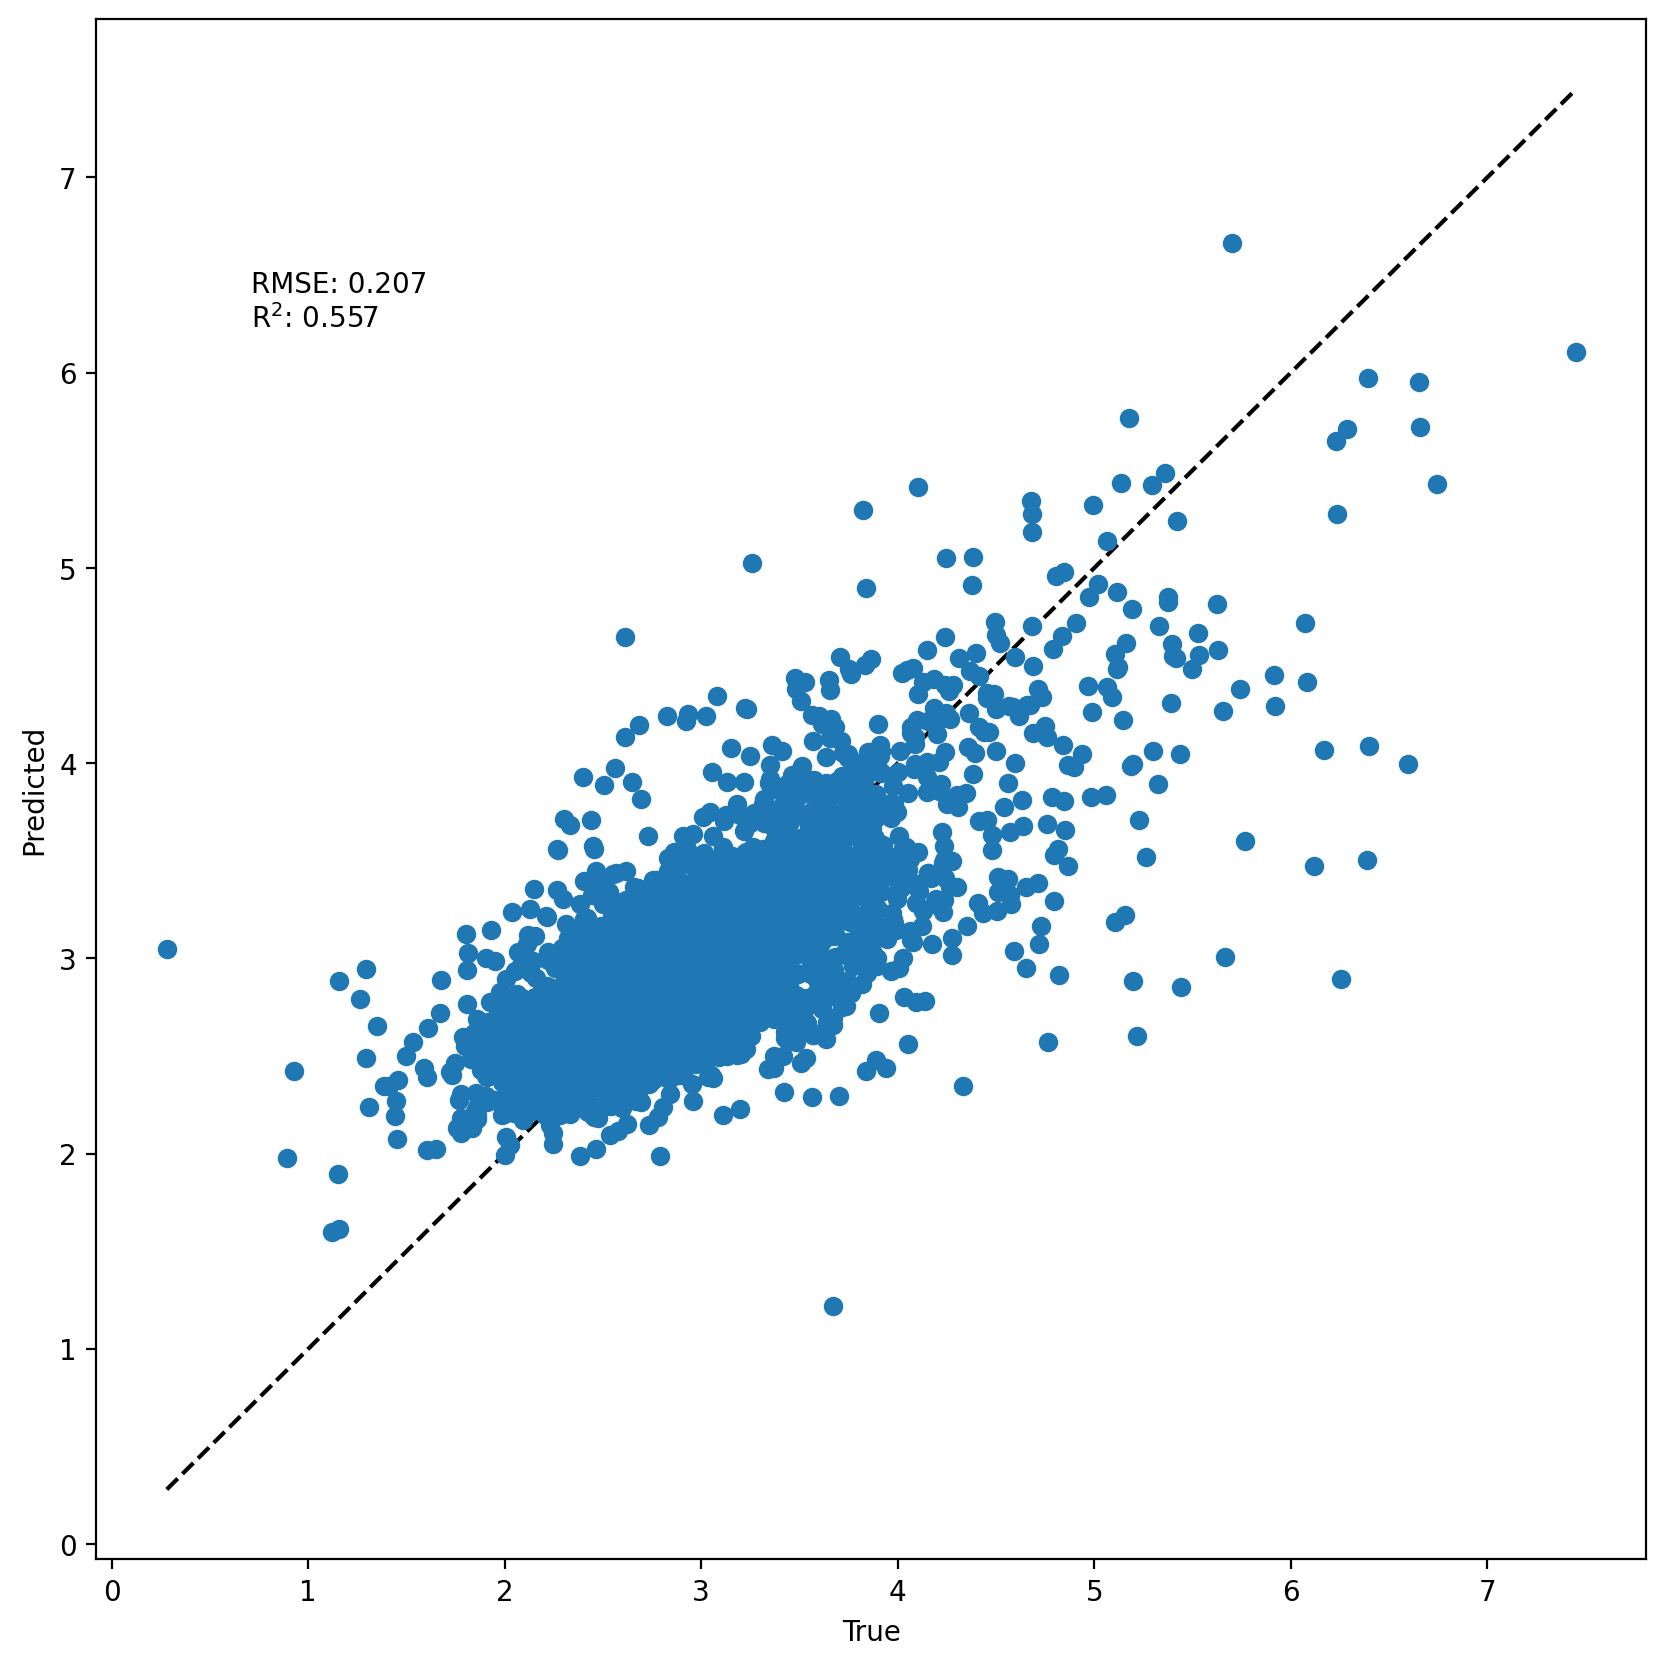

In [10]:
fig = plt.figure(figsize = (10, 10), dpi = 200)
ax = plt.gca()

ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--')
ax.plot(true, pred, linestyle = 'None', marker = 'o')

rmse = np.power((true - pred), 2).mean()
from sklearn.metrics import r2_score
r2 = r2_score(true, pred)

ax.annotate(f"RMSE: {rmse:.3f}\nR$^2$: {r2:.3f}", xy = (0.1, 0.8), xycoords = 'axes fraction')

ax.set_xlabel("True")
ax.set_ylabel("Predicted")

plt.show()